In [1]:
from __future__ import print_function

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../build/')

In [3]:
%pylab inline
np.set_printoptions(precision=4, suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [4]:
# import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator

In [5]:
import versor as vsr
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
# from game import VDMotorEstimationSolver

# Ground truth motor

In [6]:
delta = 0.6
theta = pi/6
motor = (vsr.Vec(1,2,3).unit() * delta ).trs() * vsr.Rot(vsr.Biv(1,2,3).unit() * theta)
noise_motor = vsr.Vec(-0.01,-0.01,-0.01).trs() * vsr.Rot(vsr.Biv(0,1,0) * (-np.pi/100))
print(motor)
print(noise_motor)

Mot: [ 0.87 -0.13 -0.27 -0.4 -0.16 -0.22 -0.12 0.021 ]
Mot: [ 1 0 0.031 0 0.0048 0.005 0.0052 -0.00016 ]


# Dataset

In [7]:
n_points = 10000
sigma = 0.09
points_a = [(vsr.Vec(0,0,0).null(),
             vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null()  )
            for i in range(n_points)]

points_a_noisy = [(vsr.Vec(*(np.array(a)[:3] + sigma * np.random.randn(3))).null(),
                   vsr.Vec(*(np.array(b)[:3] + sigma * np.random.randn(3))).null()) 
                  for a,b in points_a]

lines_a = [vsr.Dll(a,b).unit() for (a,b) in points_a]
lines_b = [line.spin(motor) for line in lines_a]

In [8]:
lines_a_noisy = [vsr.Dll(a,b).unit() for (a,b) in points_a_noisy]
lines_b_noisy = [line.spin(motor) for line in lines_a_noisy]

In [9]:
lines_b_noisy = [line.spin(motor).spin(noise_motor) for line in lines_a]

In [10]:
Ms = [l2 * l1.rev() for l1, l2 in zip(lines_a, lines_b)]

In [11]:
A = np.zeros((8,8))
for i in range(8):
    ei = vsr.Mot(0,0,0,0,0,0,0,0)
    ei[i] = 1.0
    A[:,i] = Ms[i] * ei

In [12]:
print(A)

[[ 0.5328  0.3835  0.0784  0.5045  0.      0.      0.      0.    ]
 [-0.1954  0.5167 -0.2875  0.66    0.      0.      0.      0.    ]
 [-0.6409  0.5963  0.752  -0.1078  0.      0.      0.      0.    ]
 [-0.5168 -0.48    0.588   0.5461  0.      0.      0.      0.    ]
 [-0.0127  0.394   0.2009  0.0789  0.6319 -0.3919  0.0024  0.729 ]
 [-0.0866 -0.4343  0.3038  0.0273  0.2114  0.8796 -0.7697 -0.4379]
 [-0.1722 -0.1262 -0.4218 -0.0452 -0.0304  0.2267  0.6228  0.1503]
 [-0.0287  0.012   0.1393  0.0322 -0.7451 -0.1459 -0.1402  0.5042]]


In [13]:
Ms[0] * vsr.Mot(0,0,0,0,0,0,0,1)

Mot: [ 0 0 0 0 0.52 -0.64 0.2 0.53 ]

In [14]:
Ms[0]

Mot: [ 0.53 -0.2 -0.64 -0.52 -0.013 -0.087 -0.17 -0.029 ]

# Estimate motor
## No noise

### 6 residuals

In [17]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
#     mes.add_line_correspondences_residual_block(a,b)
    mes.add_line_commutator_residual_block(a,b)
#     mes.add_line_dual_angle_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_6_res, summary_lines_6_res, _) = mes.solve()
print(summary_lines_6_res['full_report'])
print(em_lines_6_res)


Solver Summary (v 1.12.0-eigen-(3.3.1)-lapack-suitesparse-(4.5.3)-cxsparse-(3.1.9)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                         10000                    10000
Residual                                60000                    60000

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC        

In [18]:
em_lines_6_res * motor.rev()

Mot: [ 1 -8.5e-14 4.8e-14 -1e-13 -1.9e-14 -4.7e-14 -1.8e-14 2.1e-17 ]

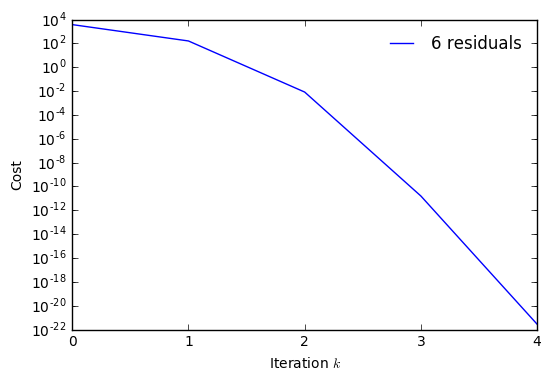

In [36]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary_lines_6_res['iterations'])['cost'], label=r'6 residuals')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
# plt.savefig('lines-nonoise.pdf')

In [16]:
def cost(a,b):
    c = b - a
    dw = c.drv().vec()
    th = theta
    d = delta
    return 4 * sin(th/2)**2 * (1.0 + np.inner(np.array(dw),np.array(dw))) + d**2 * cos(th/2)**2
np.sum([cost(a,b) for a,b in zip(lines_a, lines_b)]) / 2

3.2513259122940585

In [17]:
np.sum([np.inner(b-a, b-a) for a,b in zip(lines_a, lines_b)]) / 2

3.2731499403079023

In [18]:
np.sum([np.inner(b-a,b-a) for a,b in zip(lines_a, lines_b)] ) * 0.5

3.2731499403079023

In [22]:
np.allclose(em_lines_6_res, motor)

True

In [27]:
I = vsr.CGA(*np.zeros(32))
I[31] = 1; print(I)
I.inv()

CGA: [ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 ]


CGA: [ -0 -0 -0 -0 -0 -0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -0 -0 -0 -0 -0 -1 ]

In [24]:
print(em_lines_6_res)
print(motor * -1.0)

Mot: [ 0.87 -0.5 -2.9e-10 4e-11 2.2e-10 8.9e-11 -0.26 0.15 ]
Mot: [ -0.87 0.5 -0 -0 -0 -0 0.26 -0.15 ]


### 4 residuals

In [94]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_angle_distance_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_4_res, summary_lines_4_res, _) = mes.solve()
print(summary_lines_4_res['brief_report'])
print(em_lines_4_res)

Ceres Solver Report: Iterations: 7, Initial cost: 9.846322e-01, Final cost: 8.653327e-17, Termination: CONVERGENCE
Mot: [ 0.87 -0.5 6.1e-12 1e-09 -1e-09 2.9e-11 -0.26 0.15 ]


In [17]:
np.allclose(em_lines_4_res, motor)

True

### Plots

In [18]:
sns.set_style('whitegrid')
sns.set_context('paper')

NameError: name 'sns' is not defined

NameError: name 'pd' is not defined

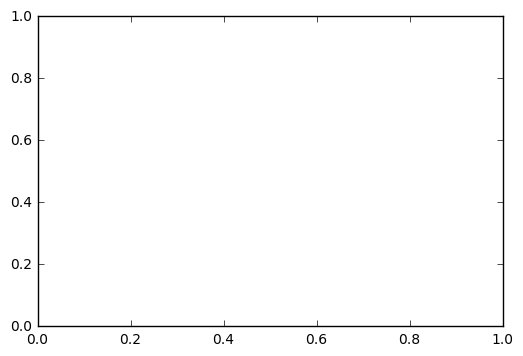

In [19]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary_lines_6_res['iterations'])['cost'], label=r'6 residuals')
ax.plot(pd.DataFrame(summary_lines_4_res['iterations'])['cost'], label=r'4 residuals')
# plt.axhline(y=summary_vd['iterations'][0]['cost'])

# ax.plot([it['cost'] for it in summary_point_1_res['iterations']])
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
# plt.savefig('lines-nonoise.pdf')

## Noise

### 6 residuals

In [12]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b_noisy):
    mes.add_line_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_6_res_noise, summary_lines_6_res_noise, _) = mes.solve()
print(summary_lines_6_res['brief_report'])
print(em_lines_6_res_noise)

Ceres Solver Report: Iterations: 6, Initial cost: 1.463360e+01, Final cost: 9.987939e-24, Termination: CONVERGENCE
Mot: [ 0.88 -1.9e-14 -0.47 6.4e-14 -0.68 -0.44 -0.16 -0.23 ]


### 4 residuals

In [21]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b_noisy):
    mes.add_line_angle_distance_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_4_res_noise, summary_lines_4_res_noise, _) = mes.solve()
print(summary_lines_4_res_noise['brief_report'])
print(em_lines_4_res_noise)

Ceres Solver Report: Iterations: 5, Initial cost: 1.444124e+00, Final cost: 7.892448e-19, Termination: CONVERGENCE
Mot: [ 0.88 8.1e-11 -0.47 5.3e-10 -0.68 -0.44 -0.16 -0.23 ]


In [22]:
np.allclose(em_lines_6_res_noise, em_lines_4_res_noise)

True

### Valkenburg and Dorst

In [ ]:
vd = VDMotorEstimationSolver()
vd.add_dual_line_observations(lines_a,lines_b_noisy)
vd_em_lines_noise = vd.solve()
print(vd_em_lines_noise)

In [ ]:
vd = VDMotorEstimationSolver()
vd.add_dual_line_observations(lines_a,lines_b)
vd_em_lines = vd.solve()
print(vd_em_lines)

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary_lines_6_res_noise['iterations'])['cost'], label=r'6 residuals')
ax.plot(pd.DataFrame(summary_lines_4_res_noise['iterations'])['cost'], label=r'4 residuals')
# plt.axhline(y=summary_vd['iterations'][0]['cost'])

# ax.plot([it['cost'] for it in summary_point_1_res['iterations']])
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
# plt.savefig('lines-noise.pdf')

# Visualization

In [13]:
scene = Scene(children=
#               [line_mesh(line,color=Colors.HOTPINK) for line in lines_a[:2]] +\
              [line_mesh(line,color=Colors.LIGHTSKYBLUE) for line in lines_b[:2]] +\
              [line_mesh(line,color='palegreen') for line in lines_b_noisy[:2]] +\
              
#               [line_mesh(line.spin(vd_em_lines),color=Colors.DEEPPINK) for line in lines_a[:2]] +\
              [line_mesh(line.spin(em_lines_6_res_noise), color=Colors.HOTPINK) for line in lines_a[:2]] +\
              [frame_mesh(),AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white',
                    width='960',
                    height='512')
renderer.width = '1024'
renderer.height = '768'
display(renderer)